# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from skimage.transform import resize
from torch import nn
from torch.nn.functional import interpolate
from torchvision.models import resnet18, resnet50
from tqdm.notebook import tqdm

from dataset import (
    HWSet,
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
    transform_shared,
)
from loss import SuperpixelCriterion, SuperpixelWeights
from model import resnet_forward_features
from util import eval_step, get_obj_score, get_performance, get_saliency, show_imarray

# sns.set_theme()

In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

Using device: cuda


# Unit tests

In [4]:
model_type = "r18"
model_path = "../models/hw-checkpoints/run-20240404-152631/a/r18_e352_best.cpt"
model = get_model(model_type, device=device)
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint["model_state_dict"])
# del checkpoint

In [62]:
dloader = get_dloader(
    "train", batch_size=4, data_dir=data_dir, noise=True, num_workers=0
)
criterion = SuperpixelCriterion(
    model_type,
    sp_loss_weight=1.0,
    layer_weights="constant",
    exact=True,
    normalize=True,
    binary=True,
    device=device,
)

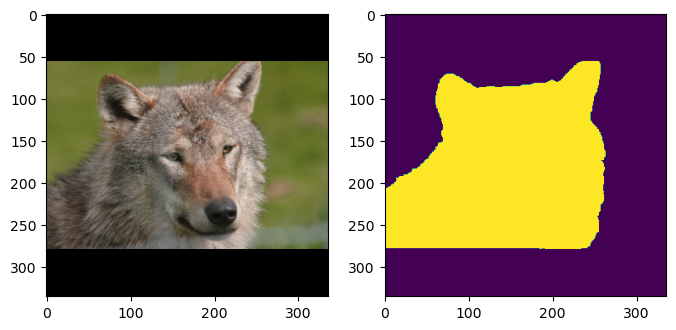

In [68]:
imgs, labels, masks, noise = next(iter(dloader))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
show_imarray(imgs[0], ax=ax0)
show_imarray(masks[0], ax=ax1)

In [69]:
sp_weights = criterion.get_sp_weights(masks.to(device))
outs = resnet_forward_features(model, imgs.to(device))
len(sp_weights), len(outs)

(5, 6)

torch.Size([4, 64, 168, 168]) torch.Size([4, 1, 168, 168])
torch.Size([4, 64, 84, 84]) torch.Size([4, 1, 84, 84])
torch.Size([4, 128, 42, 42]) torch.Size([4, 1, 42, 42])
torch.Size([4, 256, 21, 21]) torch.Size([4, 1, 21, 21])
torch.Size([4, 512, 11, 11]) torch.Size([4, 1, 11, 11])


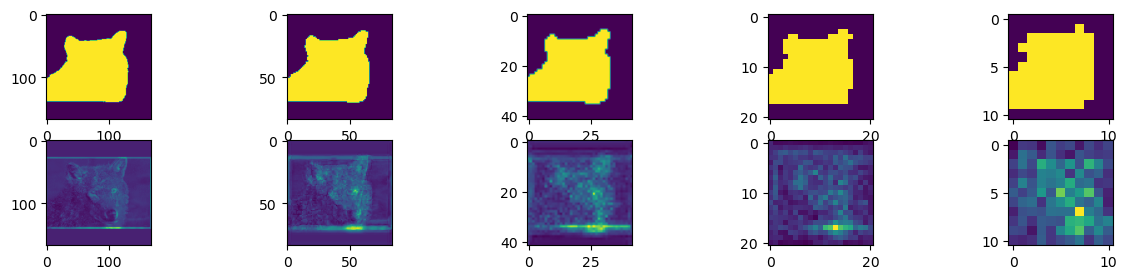

In [70]:
fig, axs = plt.subplots(2, len(sp_weights), figsize=(len(sp_weights) * 3, 3))

losses = []
for sp, sp_w, ax0, ax1 in zip(outs, sp_weights, axs[0], axs[1]):
    print(sp.size(), sp_w.size())
    show_imarray(sp_w.cpu().detach()[0], ax=ax0, vmin=0, vmax=1)
    show_imarray(sp.cpu().detach()[0].max(0)[0], ax=ax1)
    # losses.append((sp_w * torch.abs(sp)).sum() / (sp_w.sum() * sp.size(1)))
#     losses.append(
#         (
#             (sp_w * torch.abs(sp)).view(sp.size(0), -1).sum(1)
#             / (sp_w.view(sp.size(0), -1).sum(1) * sp.size(1) + 1e-7)
#         ).mean()
#     )

# loss = sum(losses) / len(sp_weights)
# loss.detach().item(), losses

In [72]:
criterion(outs, labels.type(torch.LongTensor).to(device), masks.to(device))

(tensor(3.4967, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.3732, device='cuda:0', grad_fn=<NllLossBackward0>))

In [ ]:
show_imarray(masks.numpy()[0])

In [ ]:
h, w = masks.size()
masks_resize = interpolate(
    masks.float(), size=((masks.size() // 2 + masks.size() % 2)[-2:]), mode="bilinear", antialias=True
)
show_imarray(masks_resize.numpy()[0])

In [31]:
masks.size()

torch.Size([4, 1, 336, 275])

In [25]:
masks.size()

torch.Size([4, 1, 336, 275])